 **ARIBA ADNAN
FA21/BSCS/401**

In [ ]:
!pip install -q kaggle transformers timm scikit-learn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 96.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 79.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 85.3 MB/s eta 0:00:00


In [ ]:
# Upload Kaggle API key
from google.colab import files
files.upload()  # Upload kaggle.json


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"aribaadnan","key":"1d837eee2b1ad907c83b3a1466265b5f"}'}

In [ ]:
# Setup Kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# Download dataset
!kaggle datasets download -d lukechugh/best-alzheimer-mri-dataset-99-accuracy
!unzip -q best-alzheimer-mri-dataset-99-accuracy.zip -d data

Dataset URL: https://www.kaggle.com/datasets/lukechugh/best-alzheimer-mri-dataset-99-accuracy
License(s): apache-2.0
  0% 0.00/71.5M [00:00<?, ?B/s]
100% 71.5M/71.5M [00:00<00:00, 940MB/s]


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight

import torch
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, Subset
from torch import nn, optim
import timm
from tqdm import tqdm
import seaborn as sns
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


In [ ]:
DATA_DIR = 'data/Combined Dataset'
classes = sorted(os.listdir(os.path.join(DATA_DIR, 'train')))
print("Classes:", classes)

Classes: ['Mild Impairment', 'Moderate Impairment', 'No Impairment', 'Very Mild Impairment']


In [ ]:
# Image transforms
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])


In [ ]:
full_train = datasets.ImageFolder(os.path.join(DATA_DIR, 'train'), transform=train_transform)
val_size = int(0.2 * len(full_train))
train_size = len(full_train) - val_size
train_dataset, val_dataset = torch.utils.data.random_split(full_train, [train_size, val_size])
val_dataset.dataset.transform = val_transform

test_dataset = datasets.ImageFolder(os.path.join(DATA_DIR, 'test'), transform=val_transform)


In [ ]:
# Compute class weights
labels = [label for _, label in train_dataset]
class_weights = compute_class_weight(class_weight='balanced', classes=np.arange(len(classes)), y=labels)
class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)
print("Class weights:", class_weights)

Class weights: [0.99224806 1.01436355 0.99805068 0.9956247 ]


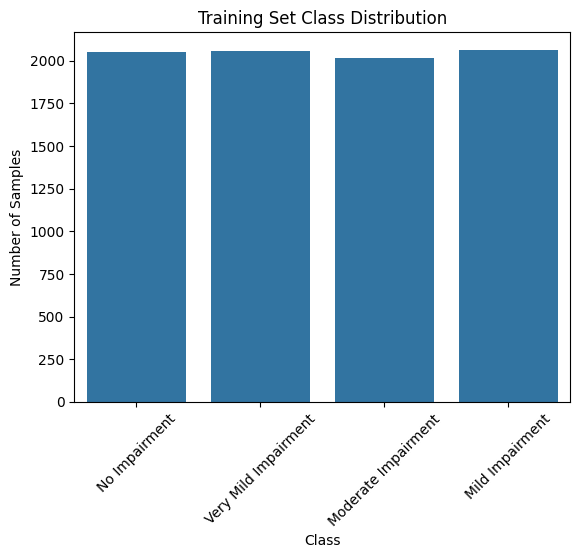

In [ ]:
import pandas as pd
from collections import Counter

label_counts = Counter([label for _, label in train_dataset])
df_label_dist = pd.DataFrame.from_dict(label_counts, orient='index', columns=['count'])
df_label_dist.index = [classes[i] for i in df_label_dist.index]

sns.barplot(x=df_label_dist.index, y='count', data=df_label_dist)
plt.title('Training Set Class Distribution')
plt.ylabel('Number of Samples')
plt.xlabel('Class')
plt.xticks(rotation=45)
plt.show()


In [ ]:
# Dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)


In [ ]:
model = timm.create_model('vit_base_patch16_224', pretrained=True, num_classes=len(classes))
model.to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
optimizer = optim.AdamW(model.parameters(), lr=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.5)
early_stop_patience = 5
def train_model(model, epochs=20):
    best_val_acc = 0
    patience_counter = 0
    history = {"train_acc": [], "val_acc": [], "train_loss": [], "val_loss": []}

    for epoch in range(epochs):
        model.train()
        train_loss, train_correct = 0, 0

        for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            train_correct += (outputs.argmax(1) == labels).sum().item()

        train_acc = train_correct / len(train_loader.dataset)
        train_loss /= len(train_loader)

        # Validation
        model.eval()
        val_loss, val_correct = 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                val_loss += criterion(outputs, labels).item()
                val_correct += (outputs.argmax(1) == labels).sum().item()

        val_acc = val_correct / len(val_loader.dataset)
        val_loss /= len(val_loader)

        history["train_acc"].append(train_acc)
        history["val_acc"].append(val_acc)
        history["train_loss"].append(train_loss)
        history["val_loss"].append(val_loss)

        scheduler.step(val_loss)

        print(f"Epoch {epoch+1}: Train Acc={train_acc:.4f}, Val Acc={val_acc:.4f}")

        if val_acc > best_val_acc:
            best_val_acc = val_acc
            patience_counter = 0
            torch.save(model.state_dict(), "best_vit_model.pth")
        else:
            patience_counter += 1
            if patience_counter >= early_stop_patience:
                print("Early stopping triggered.")
                break

    return history


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

In [ ]:
history = train_model(model, epochs=20)


Epoch 1/20: 100%|██████████| 256/256 [04:31<00:00,  1.06s/it]


Epoch 1: Train Acc=0.2998, Val Acc=0.2642


Epoch 2/20: 100%|██████████| 256/256 [04:43<00:00,  1.11s/it]


Epoch 2: Train Acc=0.5835, Val Acc=0.6870


Epoch 3/20: 100%|██████████| 256/256 [04:44<00:00,  1.11s/it]


Epoch 3: Train Acc=0.7657, Val Acc=0.8008


Epoch 4/20: 100%|██████████| 256/256 [04:44<00:00,  1.11s/it]


Epoch 4: Train Acc=0.8348, Val Acc=0.8208


Epoch 5/20: 100%|██████████| 256/256 [04:43<00:00,  1.11s/it]


Epoch 5: Train Acc=0.8945, Val Acc=0.8291


Epoch 6/20: 100%|██████████| 256/256 [04:43<00:00,  1.11s/it]


Epoch 6: Train Acc=0.9331, Val Acc=0.9097


Epoch 7/20: 100%|██████████| 256/256 [04:43<00:00,  1.11s/it]


Epoch 7: Train Acc=0.9603, Val Acc=0.8975


Epoch 8/20: 100%|██████████| 256/256 [04:43<00:00,  1.11s/it]


Epoch 8: Train Acc=0.9795, Val Acc=0.9170


Epoch 9/20: 100%|██████████| 256/256 [04:43<00:00,  1.11s/it]


Epoch 9: Train Acc=0.9705, Val Acc=0.9214


Epoch 10/20: 100%|██████████| 256/256 [04:43<00:00,  1.11s/it]


Epoch 10: Train Acc=0.9930, Val Acc=0.9497


Epoch 11/20: 100%|██████████| 256/256 [04:44<00:00,  1.11s/it]


Epoch 11: Train Acc=0.9974, Val Acc=0.9575


Epoch 12/20: 100%|██████████| 256/256 [04:43<00:00,  1.11s/it]


Epoch 12: Train Acc=0.9979, Val Acc=0.9209


Epoch 13/20: 100%|██████████| 256/256 [04:44<00:00,  1.11s/it]


Epoch 13: Train Acc=0.9945, Val Acc=0.9644


Epoch 14/20: 100%|██████████| 256/256 [04:44<00:00,  1.11s/it]


Epoch 14: Train Acc=0.9945, Val Acc=0.9541


Epoch 15/20: 100%|██████████| 256/256 [04:44<00:00,  1.11s/it]


Epoch 15: Train Acc=0.9944, Val Acc=0.9619


Epoch 16/20: 100%|██████████| 256/256 [04:44<00:00,  1.11s/it]


Epoch 16: Train Acc=0.9939, Val Acc=0.9604


Epoch 17/20: 100%|██████████| 256/256 [04:44<00:00,  1.11s/it]


Epoch 17: Train Acc=0.9973, Val Acc=0.9668


Epoch 18/20: 100%|██████████| 256/256 [04:43<00:00,  1.11s/it]


Epoch 18: Train Acc=0.9937, Val Acc=0.9585


Epoch 19/20: 100%|██████████| 256/256 [04:44<00:00,  1.11s/it]


Epoch 19: Train Acc=0.9956, Val Acc=0.9556


Epoch 20/20: 100%|██████████| 256/256 [04:44<00:00,  1.11s/it]


Epoch 20: Train Acc=0.9980, Val Acc=0.9741


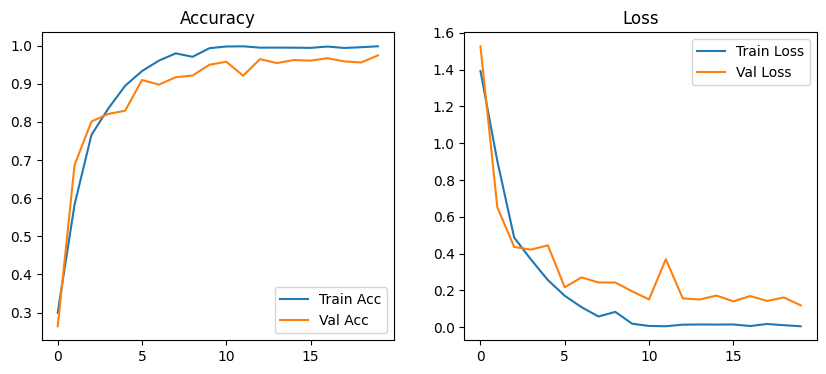

In [ ]:
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history["train_acc"], label="Train Acc")
plt.plot(history["val_acc"], label="Val Acc")
plt.title("Accuracy")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history["train_loss"], label="Train Loss")
plt.plot(history["val_loss"], label="Val Loss")
plt.title("Loss")
plt.legend()
plt.show()

In [ ]:
model.load_state_dict(torch.load("best_vit_model.pth"))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        preds = outputs.argmax(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


Classification Report:
                      precision    recall  f1-score   support

     Mild Impairment       0.95      0.92      0.93       179
 Moderate Impairment       1.00      0.92      0.96        12
       No Impairment       0.95      0.97      0.96       640
Very Mild Impairment       0.94      0.93      0.93       448

            accuracy                           0.95      1279
           macro avg       0.96      0.93      0.95      1279
        weighted avg       0.95      0.95      0.95      1279



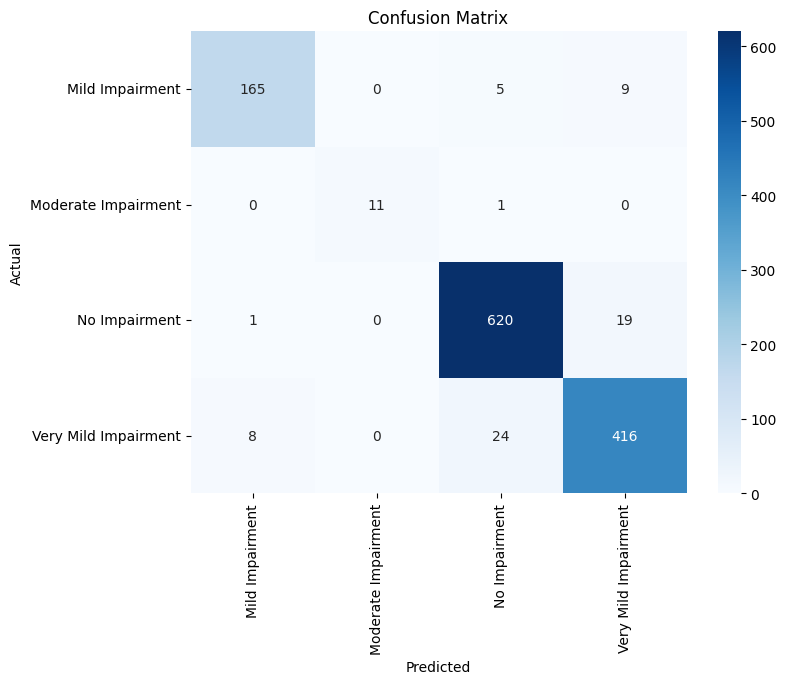

                      precision    recall  f1-score   support

     Mild Impairment       0.95      0.92      0.93       179
 Moderate Impairment       1.00      0.92      0.96        12
       No Impairment       0.95      0.97      0.96       640
Very Mild Impairment       0.94      0.93      0.93       448

            accuracy                           0.95      1279
           macro avg       0.96      0.93      0.95      1279
        weighted avg       0.95      0.95      0.95      1279



In [ ]:
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=classes))

# ===================== CONFUSION MATRIX =====================
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

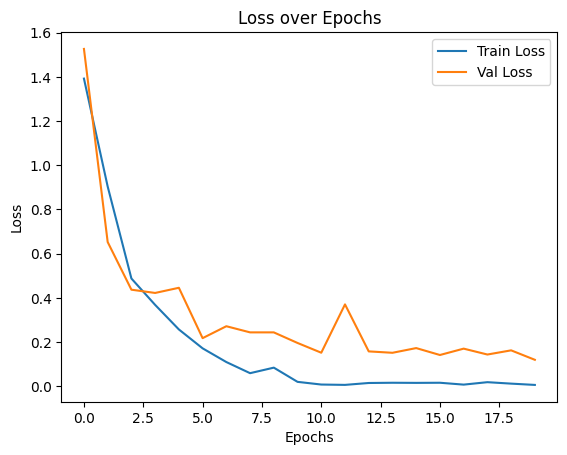

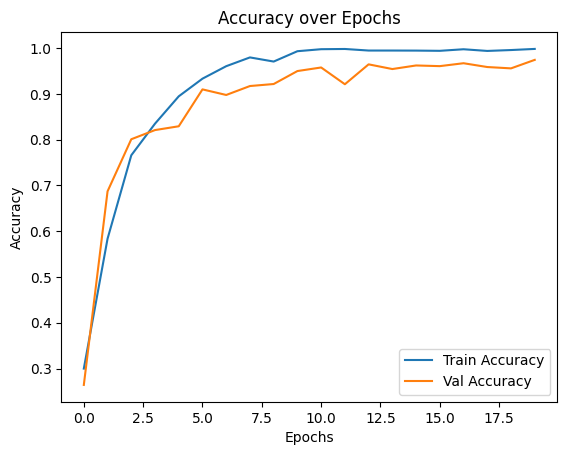

In [ ]:
plt.plot(history["train_loss"], label='Train Loss') # Use history["train_loss"] instead of train_losses
plt.plot(history["val_loss"], label='Val Loss')     # Use history["val_loss"] instead of val_losses
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.show()

plt.plot(history["train_acc"], label='Train Accuracy') # Use history["train_acc"] instead of train_accuracies
plt.plot(history["val_acc"], label='Val Accuracy')     # Use history["val_acc"] instead of val_accuracies
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.show()

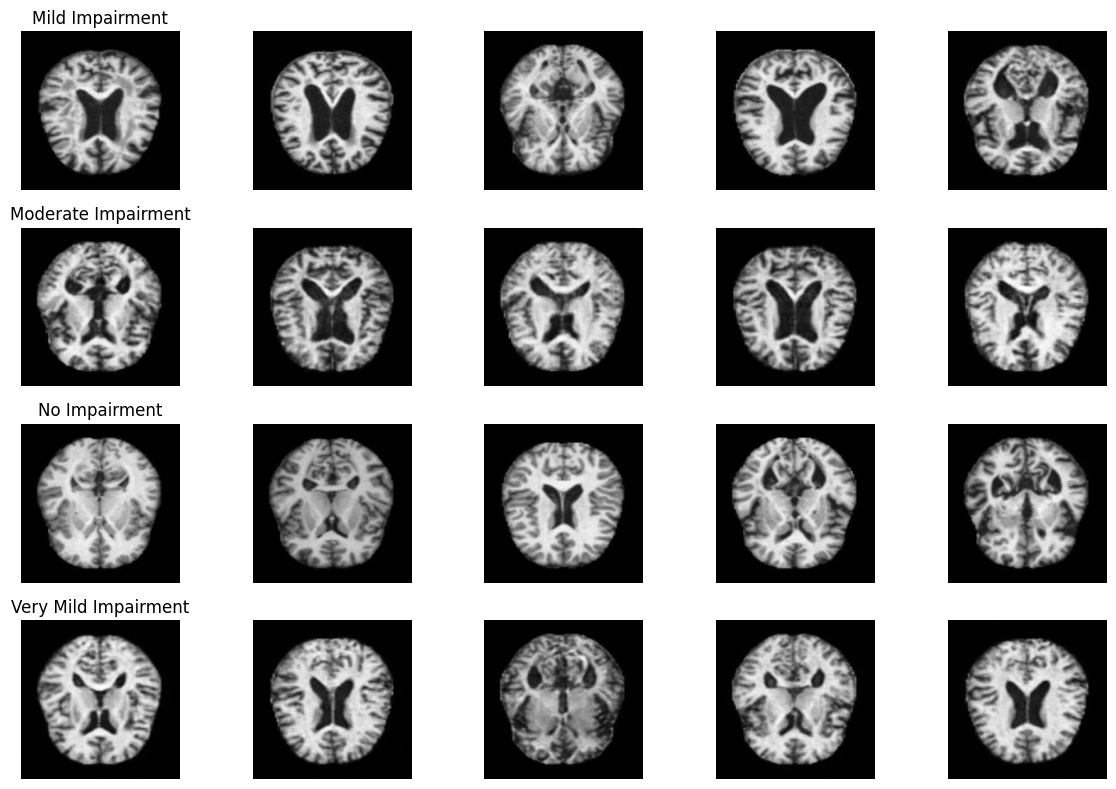

In [ ]:
def show_samples(dataset, class_names):
    fig, axs = plt.subplots(len(class_names), 5, figsize=(12, 8))
    for i, cls in enumerate(class_names):
        cls_idx = classes.index(cls)
        cls_samples = [img for img, label in dataset if label == cls_idx][:5]
        for j, img in enumerate(cls_samples):
            axs[i, j].imshow(img.permute(1, 2, 0) * 0.5 + 0.5)
            axs[i, j].axis('off')
            if j == 0:
                axs[i, j].set_title(cls)
    plt.tight_layout()
    plt.show()

show_samples(train_dataset, classes)
